In [1]:
#pip install mne
import mne
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import os
from scipy import signal
from matplotlib.pyplot import figure

Считаем данные в формате edf

In [2]:
file = "Data VECG\PatientA__Exam_1_0.edf"
data = mne.io.read_raw_edf(file)
raw_data = data.get_data()
# you can get the metadata included in the file and a list of all channels:
info = data.info
channels = data.ch_names

Extracting EDF parameters from d:\Python_notebooks\repository_Koldim2001\vector_ECG\Data VECG\PatientA__Exam_1_0.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [3]:
channels

['ECG I', 'ECG II', 'ECG V1', 'ECG V2', 'ECG V3', 'ECG V4', 'ECG V5', 'ECG V6']

In [4]:
info

<Info | 7 non-empty values
 bads: []
 ch_names: ECG I, ECG II, ECG V1, ECG V2, ECG V3, ECG V4, ECG V5, ECG V6
 chs: 8 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2011-08-09 00:00:00 UTC
 nchan: 8
 projs: []
 sfreq: 500.0 Hz
>

In [5]:
fd = 500 # Частота дискретизации
raw_data.shape

(8, 5000)

In [6]:
df = pd.DataFrame(data=raw_data.T,    # values
...              index=range(raw_data.shape[1]),    # 1st column as index
...              columns=channels)  # 1st row as the column names
df

,ECG I,ECG II,ECG V1,ECG V2,ECG V3,ECG V4,ECG V5,ECG V6
0,-0.000163,0.000236,-0.000398,-0.000547,-0.000354,-0.000382,-0.000423,-0.000447
1,-0.000157,0.000240,-0.000397,-0.000548,-0.000354,-0.000383,-0.000425,-0.000449
2,-0.000157,0.000240,-0.000397,-0.000549,-0.000355,-0.000383,-0.000424,-0.000446
3,-0.000165,0.000238,-0.000399,-0.000549,-0.000357,-0.000383,-0.000423,-0.000441
4,-0.000167,0.000239,-0.000402,-0.000548,-0.000356,-0.000384,-0.000422,-0.000440
...,...,...,...,...,...,...,...,...
4995,-0.000185,0.000182,0.000005,-0.000557,-0.000245,-0.000043,-0.000370,-0.000295
4996,-0.000184,0.000184,0.000004,-0.000554,-0.000243,-0.000042,-0.000369,-0.000295
4997,-0.000182,0.000185,0.000002,-0.000554,-0.000243,-0.000041,-0.000368,-0.000295
4998,-0.000182,0.000184,0.000003,-0.000554,-0.000245,-0.000042,-0.000368,-0.000296


In [7]:
Ts = 1/fd
t = []
for i in range(raw_data.shape[1]):
    t.append(i*Ts)
max(t)

9.998

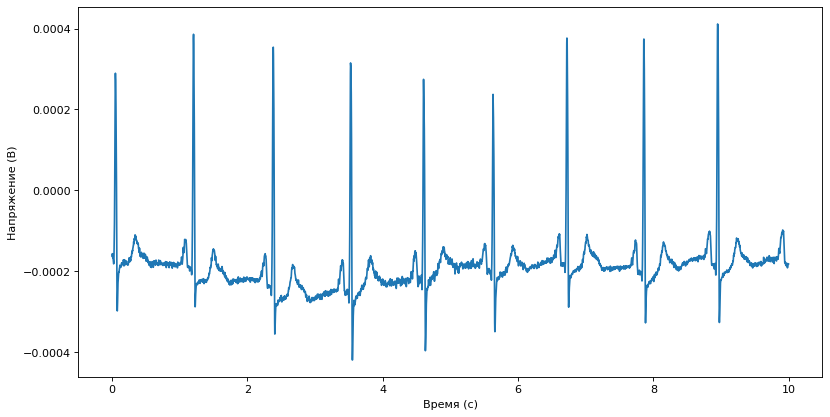

In [8]:
plt.figure(figsize=(12, 6), dpi=80)
plt.plot(t, df['ECG I'])
plt.xlabel('Время (с)')
plt.ylabel('Напряжение (В)')
plt.show()

In [9]:
from catboost import CatBoostClassifier
model = CatBoostClassifier()      # parameters not required.
model.load_model('boosting_model_ECG.cbm');

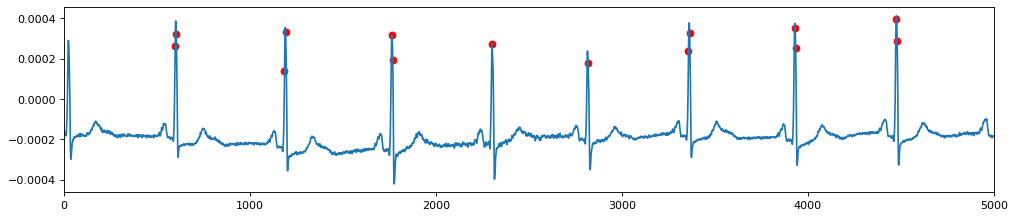

In [10]:
sig = np.array(df['ECG I'])
window = 200
dataset_check = []
middles = []
for i in range(0, len(sig)-window, 6):
    piece = sig[i:i+window] / np.max(np.abs(sig[i:i+window]))
    piece = piece - np.mean(piece)
    middle = (i + i + window) / 2
    middles.append(middle)
    dataset_check.append(piece)
df_check = pd.DataFrame(dataset_check)
test_preds = model.predict(df_check, prediction_type="Class")
peaks = np.where(test_preds>0)[0]

# Сделаем временный сигнал, который всегда имеет min значение = 0
temp_sig = sig
if min(sig) < 0:
    temp_sig = sig + abs(min(sig))
if min(sig) > 0:
    temp_sig = sig - abs(min(sig))

h = max(temp_sig)/1.5  # Выберем только те пики, которые >
true_peaks = []

for i in peaks:
    m = int(middles[i])
    if temp_sig[m]>h:
        true_peaks.append(i)


middles = np.asarray(middles)
figure(figsize=(15, 3), dpi=80)
plt.plot(sig)
plt.scatter(middles[true_peaks], [list(sig)[x] for x in list((middles[true_peaks]).astype(np.int64))], color='red')
plt.xlim([0, 5000]);

Сделаем так, чтобы один кардиоцикл имел ровно 1 задетектированный пик. 
Условие будет такое: если между соседними пиками расстояние меньше чем 0.2 мс, тогда оставить надо как значение пика - среднее значение между точками

In [11]:
coordinates = middles[true_peaks].astype(np.int64)
coordinates = np.concatenate((coordinates, max(coordinates)+10000),axis=None)
final_coord = []
val_last = 0
data_points = []
for val in coordinates:
    if val - val_last > (0.2/Ts):
        if len(data_points)!=0:
            final_coord.append(int(np.array(data_points).mean()))
            data_points = []
    data_points.append(val)
    val_last = val

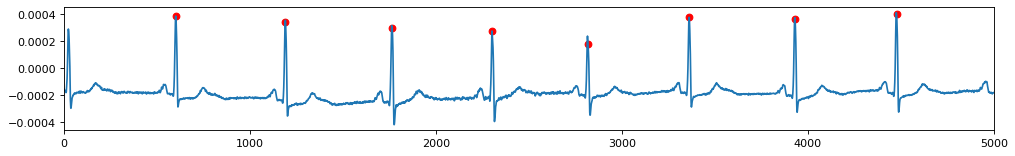

In [12]:
figure(figsize=(15, 2), dpi=80)
plt.plot(sig)
plt.scatter(final_coord, sig[final_coord], color='red')
plt.xlim([0, 5000]);

Так как все сигналы записаны отновременно со всех отведений, поэтому эти же найденные координаты на 1 отведении можно перенести с легкостью на все остальные

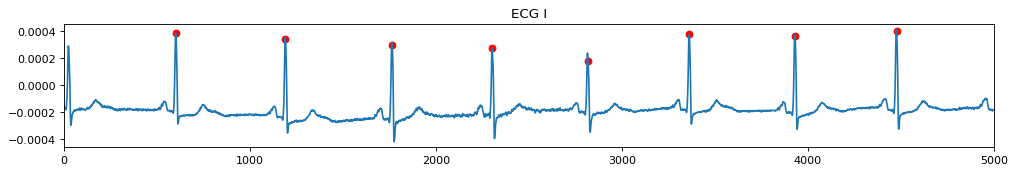

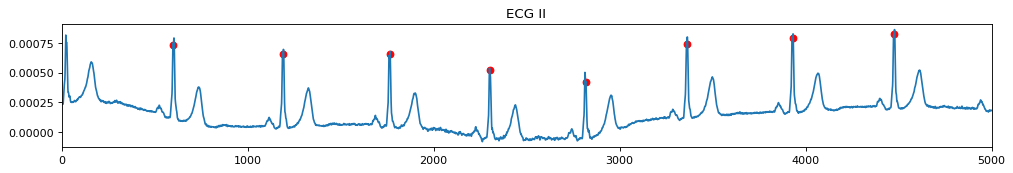

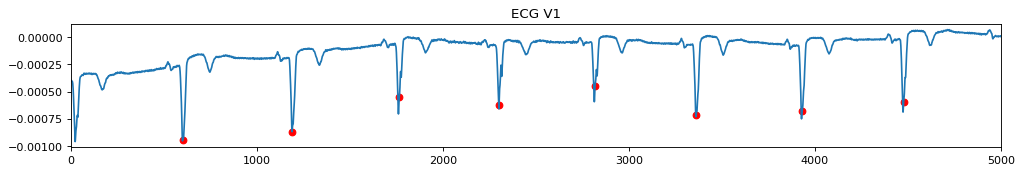

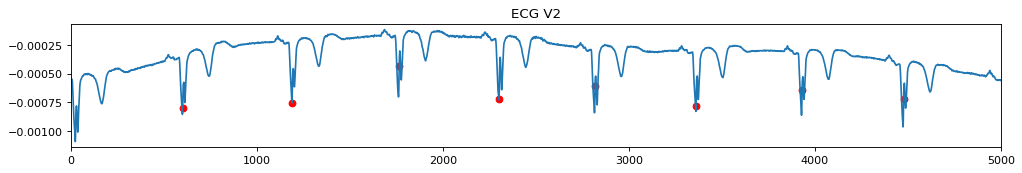

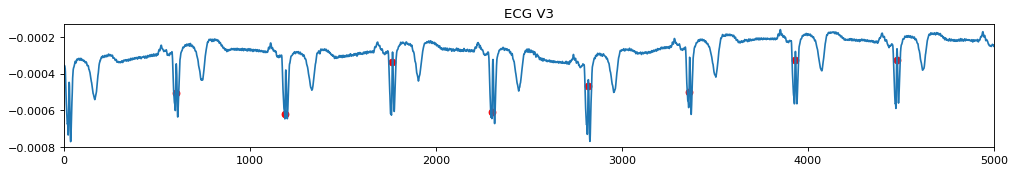

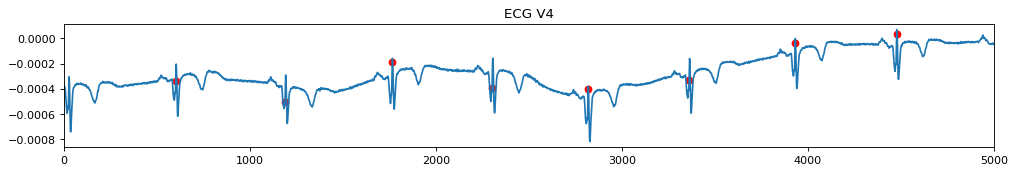

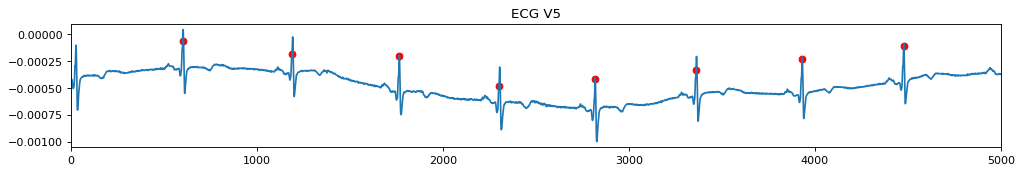

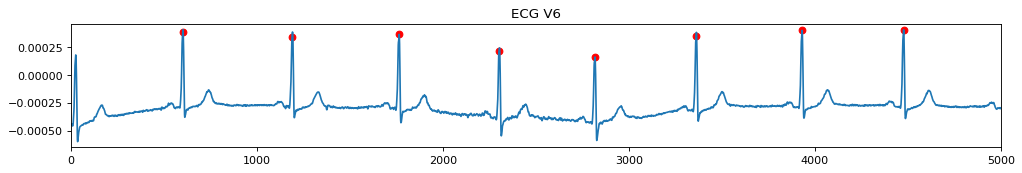

In [13]:
for graph in channels:
    sig = np.array(df[graph])
    figure(figsize=(15, 2), dpi=80)
    plt.plot(sig)
    plt.scatter(final_coord, sig[final_coord], color='red')
    plt.title(graph)
    plt.xlim([0, 5000]);

Можно еще попробовать реализовать фильтрацию ФВЧ чтобы убрать артефакты дыхания

Фильтр 3 порядка с f среза = 0.5 Гц

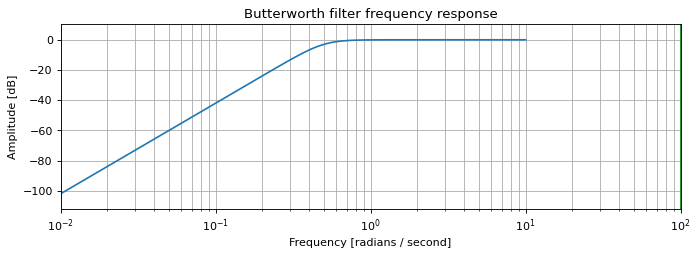

In [14]:
b, a = signal.butter(3, 0.5, 'hp', analog=True)
w, h = signal.freqs(b, a)
figure(figsize=(10, 3), dpi=80)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(100, color='green') # cutoff frequency
plt.show()

Возьмем как пример сигнал со 2 отведения:

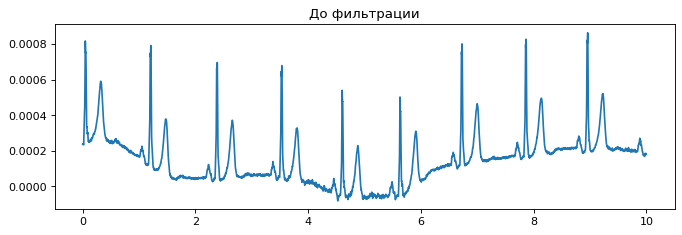

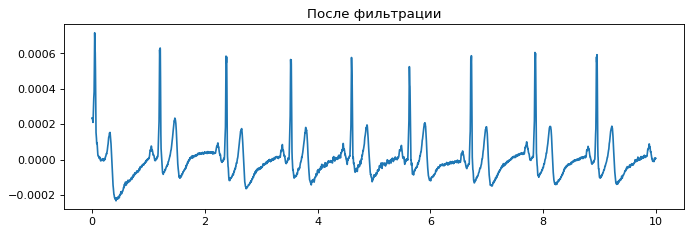

In [15]:
sig = np.array(df['ECG II'])
sos = signal.butter(3, 0.5, 'hp', fs=fd, output='sos')
filtered = signal.sosfilt(sos, sig)
figure(figsize=(10, 3), dpi=80)
plt.plot(t, sig)
plt.title('До фильтрации')
plt.show()
figure(figsize=(10, 3), dpi=80)
plt.plot(t, filtered)
plt.title('После фильтрации')
plt.show()

Так что можно перед нахождением вЭКГ заранее фильтром ФВЧ отфильтровать сигналы всех отведений. Данное действие реализуем опционально

### Поиск вЭКГ

[Статья, в которой есть формула для вычисления проекций диполя](article.pdf)

Нам требуется выделить 1 период кардиоцикла и для него расчитать. Я собираюсь взять 3 и 4 периоды

In [27]:
i = int(input('Введите значение с какого периода начать отсчет'))
print(f"Запрошен {i} период")
start = final_coord[i-1]
end = final_coord[i]

Запрошен 5 период


In [28]:
df_term = df.iloc[start:end,:]
df_term

,ECG I,ECG II,ECG V1,ECG V2,ECG V3,ECG V4,ECG V5,ECG V6
2818,0.000180,0.000420,-0.000445,-0.000605,-0.000467,-0.000402,-0.000415,0.000161
2819,0.000153,0.000423,-0.000431,-0.000550,-0.000434,-0.000381,-0.000408,0.000134
2820,0.000119,0.000404,-0.000420,-0.000529,-0.000433,-0.000393,-0.000442,0.000080
2821,0.000084,0.000355,-0.000406,-0.000521,-0.000451,-0.000429,-0.000506,0.000000
2822,0.000045,0.000285,-0.000388,-0.000526,-0.000490,-0.000493,-0.000601,-0.000116
...,...,...,...,...,...,...,...,...
3356,0.000075,0.000447,-0.000508,-0.000727,-0.000553,-0.000438,-0.000509,0.000061
3357,0.000155,0.000555,-0.000578,-0.000751,-0.000556,-0.000417,-0.000455,0.000153
3358,0.000239,0.000667,-0.000652,-0.000782,-0.000569,-0.000408,-0.000414,0.000239
3359,0.000319,0.000745,-0.000714,-0.000817,-0.000585,-0.000413,-0.000401,0.000291


In [29]:
# Задублируем первый отчет чтебы сделать график непрерывным:
df_row = df.iloc[start:start+1,:]
df_term = pd.concat([df_term, df_row])
df_row

,ECG I,ECG II,ECG V1,ECG V2,ECG V3,ECG V4,ECG V5,ECG V6
2818,0.00018,0.00042,-0.000445,-0.000605,-0.000467,-0.000402,-0.000415,0.000161


In [30]:
DI = df_term['ECG I']
DII = df_term['ECG II']
V1 = df_term['ECG V1']
V2 = df_term['ECG V2']
V3 = df_term['ECG V3']
V4 = df_term['ECG V4']
V5 = df_term['ECG V5']
V6 = df_term['ECG V6']

In [31]:
df_term['x'] = -(-0.172*V1-0.074*V2+0.122*V3+0.231*V4+0.239*V5+0.194*V6+0.156*DI-0.01*DII)
df_term['y'] = (0.057*V1-0.019*V2-0.106*V3-0.022*V4+0.041*V5+0.048*V6-0.227*DI+0.887*DII)
df_term['z'] = -(-0.229*V1-0.31*V2-0.246*V3-0.063*V4+0.055*V5+0.108*V6+0.022*DI+0.102*DII)

In [32]:
df_term

,ECG I,ECG II,ECG V1,ECG V2,ECG V3,ECG V4,ECG V5,ECG V6,x,y,z
2818,0.000180,0.000420,-0.000445,-0.000605,-0.000467,-0.000402,-0.000415,0.000161,0.000072,0.000367,-0.000471
2819,0.000153,0.000423,-0.000431,-0.000550,-0.000434,-0.000381,-0.000408,0.000134,0.000078,0.000371,-0.000439
2820,0.000119,0.000404,-0.000420,-0.000529,-0.000433,-0.000393,-0.000442,0.000080,0.000108,0.000358,-0.000420
2821,0.000084,0.000355,-0.000406,-0.000521,-0.000451,-0.000429,-0.000506,0.000000,0.000157,0.000319,-0.000403
2822,0.000045,0.000285,-0.000388,-0.000526,-0.000490,-0.000493,-0.000601,-0.000116,0.000230,0.000263,-0.000388
...,...,...,...,...,...,...,...,...,...,...,...
3357,0.000155,0.000555,-0.000578,-0.000751,-0.000556,-0.000417,-0.000455,0.000153,0.000070,0.000495,-0.000580
3358,0.000239,0.000667,-0.000652,-0.000782,-0.000569,-0.000408,-0.000414,0.000239,0.000015,0.000579,-0.000634
3359,0.000319,0.000745,-0.000714,-0.000817,-0.000585,-0.000413,-0.000401,0.000291,-0.000020,0.000632,-0.000679
3360,0.000364,0.000758,-0.000731,-0.000827,-0.000570,-0.000395,-0.000387,0.000316,-0.000044,0.000632,-0.000687


<image src="https://cf.ppt-online.org/files/slide/j/jwUOHvuLkin8pdx01KmTBc7YRIDs5JZgF9tXyN/slide-37.jpg">

[]

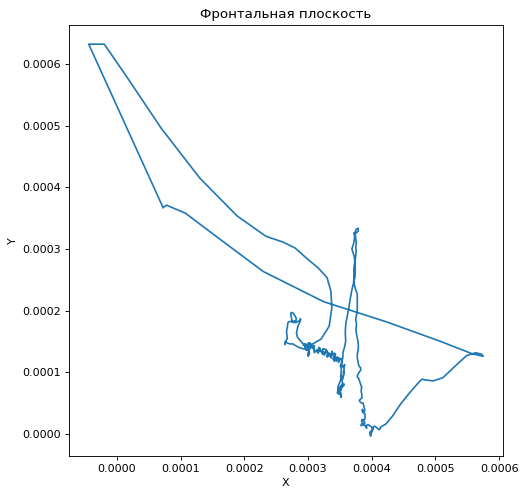

In [33]:
plt.figure(figsize=(7, 7), dpi=80)
plt.plot(df_term.x,df_term.y)
plt.title('Фронтальная плоскость')
plt.xlabel('X')
plt.ylabel('Y')
plt.plot()

[]

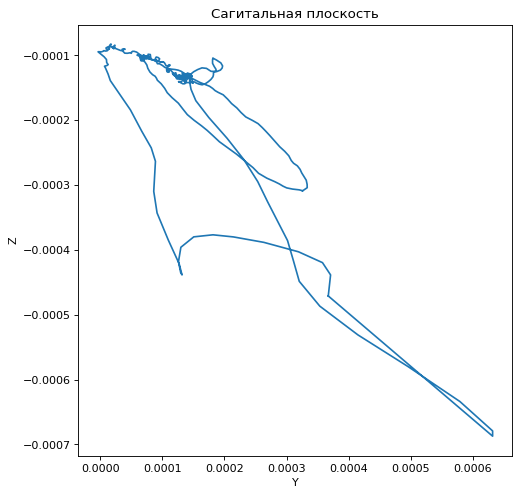

In [34]:
plt.figure(figsize=(7, 7), dpi=80)
plt.plot(df_term.y,df_term.z)
plt.title('Сагитальная плоскость')
plt.xlabel('Y')
plt.ylabel('Z')
plt.plot()

[]

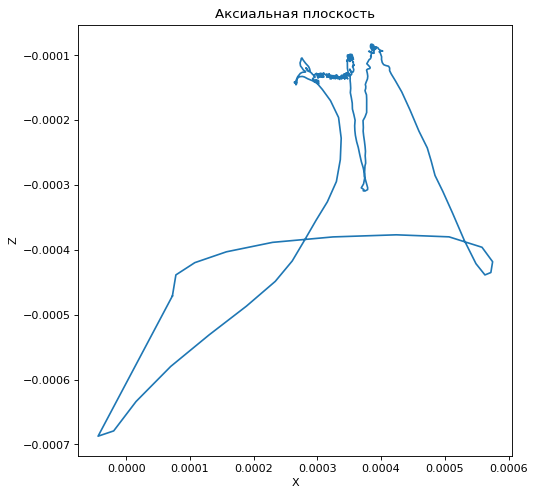

In [35]:
plt.figure(figsize=(7, 7), dpi=80)
plt.plot(df_term.x, df_term.z)
plt.title('Аксиальная плоскость')
plt.xlabel('X')
plt.ylabel('Z')
plt.plot()

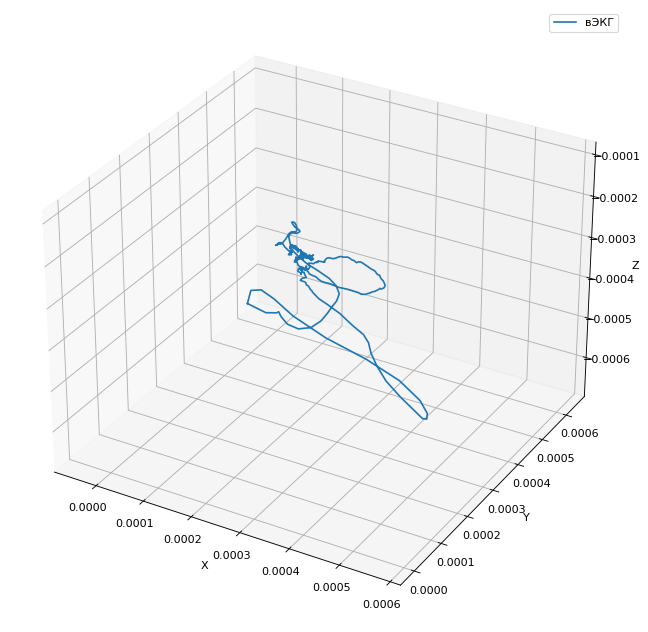

In [36]:
ax = plt.figure(figsize=(10, 10), dpi=80).add_subplot(projection='3d')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.plot(df_term.x,df_term.y,df_term.z, label='вЭКГ')
ax.legend()

plt.show()

Пример реализации пикового детектирования при фильтрации ФВЧ всех входных сигналов ЭЭГ

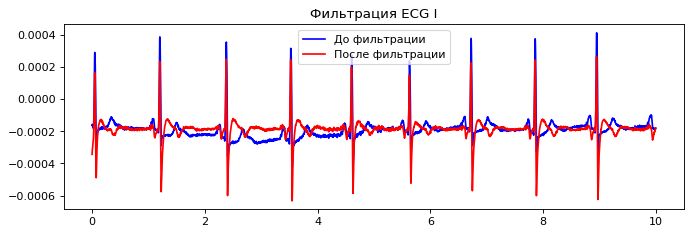

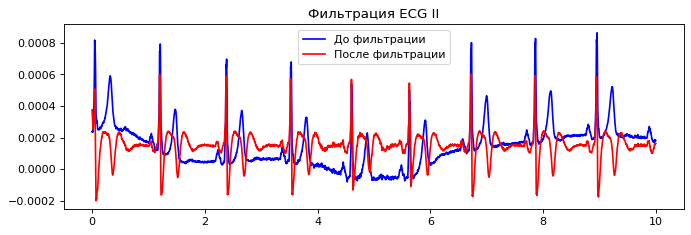

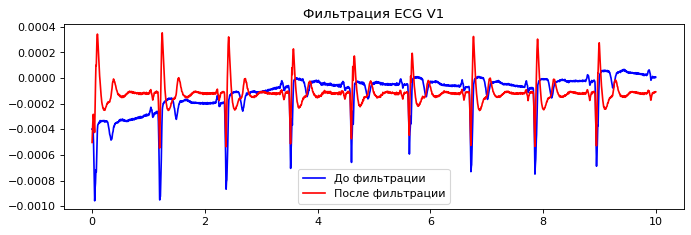

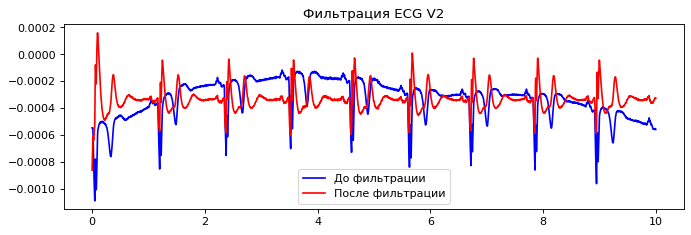

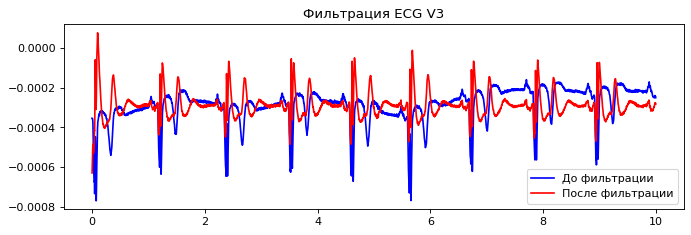

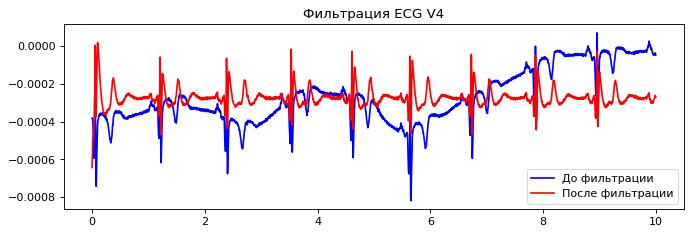

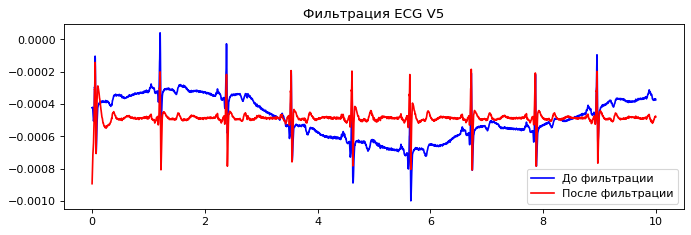

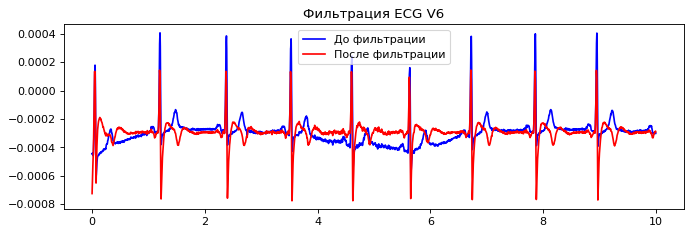

In [41]:
        f_sreza = float(input('Введите частоту среза ФВЧ фильтра 3 порядка в Гц:'))
        df_new = pd.DataFrame()
        for graph in channels:
            sig = np.array(df[graph])
            sos = signal.butter(3, f_sreza, 'hp', fs=fd, output='sos')
            avg = np.mean(sig)
            filtered = signal.sosfilt(sos, sig)
            filtered += avg
            figure(figsize=(10, 3), dpi=80)
    
            plt.plot(t, sig, color='blue')
            plt.plot(t, filtered, color='red')
            plt.title('Фильтрация '+ str(graph))
            plt.legend(["До фильтрации", "После фильтрации"])
            plt.show()
        
            df_new[graph] = pd.Series(filtered)

        df = df_new
        t = []
        for i in range(raw_data.shape[1]):
            t.append(i*Ts)
        sig = np.array(df['ECG I'])
        dataset_check = []
        middles = []
        for i in range(0, len(sig)-window, 6):
            piece = sig[i:i+window] / np.max(np.abs(sig[i:i+window]))
            piece = piece - np.mean(piece)
            middle = (i + i + window) / 2
            middles.append(middle)
            dataset_check.append(piece)
        df_check = pd.DataFrame(dataset_check)
        test_preds = model.predict(df_check, prediction_type="Class")
        peaks = np.where(test_preds > 0)[0]

        # Сделаем временный сигнал, который всегда имеет min значение = 0
        temp_sig = sig
        if min(sig) < 0:
            temp_sig = sig + abs(min(sig))
        if min(sig) > 0:
            temp_sig = sig - abs(min(sig))

        h = max(temp_sig)/1.5  # Выберем только те пики, которые >
        true_peaks = []

        for i in peaks:
            m = int(middles[i])
            if temp_sig[m]>h:
                true_peaks.append(i)

Добавил возможность на вход функции подавать сразу значения с каого по какой период необходимо построить результат. Для этого надо в качестве параметра n_term передать значение списка [номер первого периода, до какого периода включительно]

---

## Итоговая функция vECG:
Входные параметры: <br>
>file <br>

Необходимо передать путь к файлу (формат .edf)<br>
>n_term <br>

Можно передать номер периода ЭКГ сигнала (тип int)<br>
Или передать пременную типа list, в которой первый элемент - с какого периода начать (лучше >1), а второй элемент - номер периода до которого вести запись (включительно) <br>
ex: [2,4] - выдаст результат вЭКГ для диапазона со 2 по 4 пориод включительно

>filt <br>

Данный параметр указывает, нужно ли проводить цифровую фильтрацию с помошью фильтра Баттерворта 3 порядка (ФВЧ). Данная фильтрация позволит убрать низкочастотные артефакты дыхания и улучшит качество работы пикового детектирования, которое реализуется с помощью предобученной модели градиентного бустинга. (Данный параметр filt по умолчанию равен False)

>f_sreza <br>

Данный параметр задает величину частоты среза ФВЧ фильтра. Так что его стоит использовать лишь при работе с n_term=True
(Данный параметр f_sreza по умолчанию равен 0.5)

### Как запускать код на python 3:

```rb
# Загрузка функции и требуемых библиотек
from func import *
!pip install -r requirements.txt

# Запуск функции:
vECG(file="Data VECG\PatientA__Exam_1_0.edf", n_term=3, filt=True, f_sreza=0.5)
```



Запустим данный код локально без загрузки библиотек из файла requirements.txt

Extracting EDF parameters from d:\Python_notebooks\repository_Koldim2001\vector_ECG\Data VECG\PatientA__Exam_1_0.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Запрошен 3 период
Результаты вычисления:


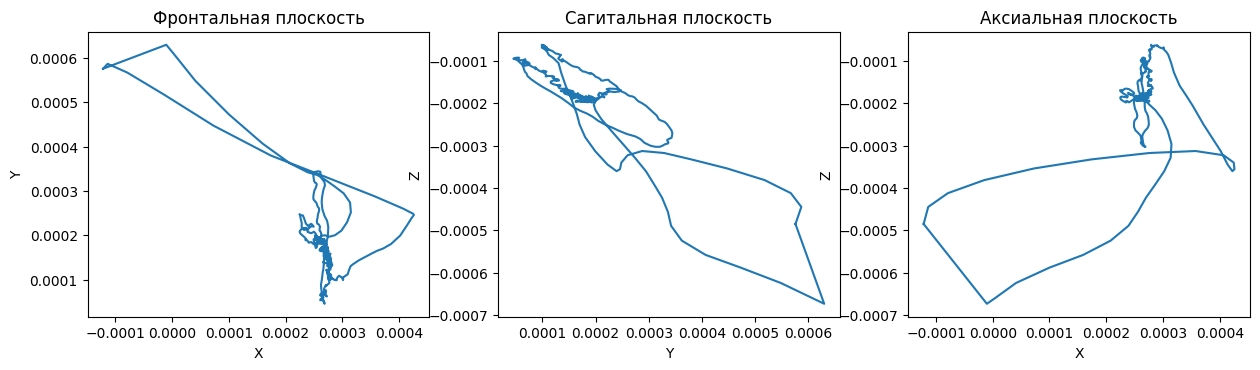

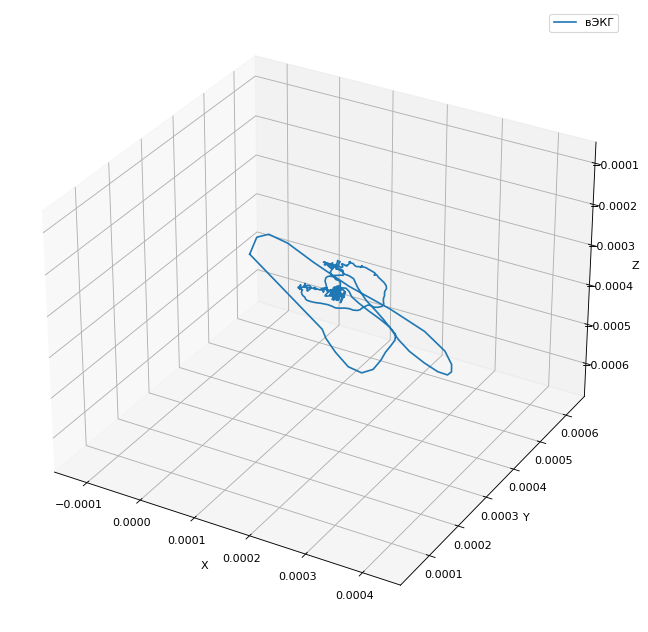

In [19]:
from func import *

vECG(file="Data VECG\PatientA__Exam_1_0.edf", n_term=3, filt=True, f_sreza=0.5)

## Итоговая функция c демонстрацией промежуточных этапов:

Может понадобиться для откладки

Extracting EDF parameters from d:\Python_notebooks\repository_Koldim2001\vector_ECG\Data VECG\PatientA__Exam_1_0.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


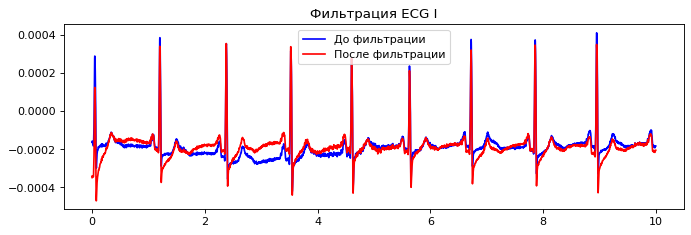

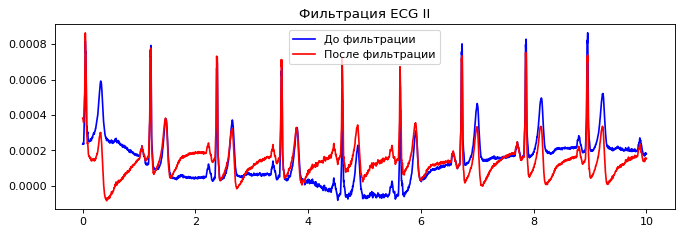

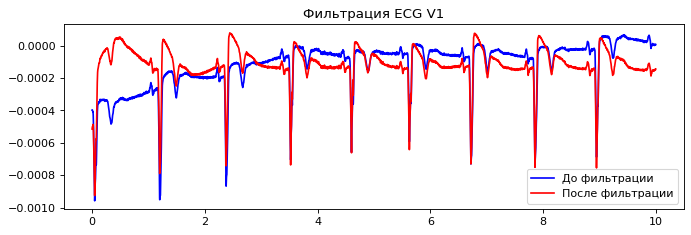

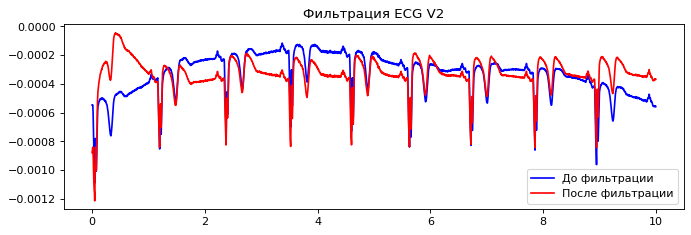

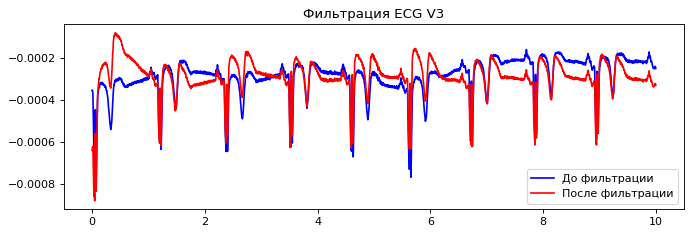

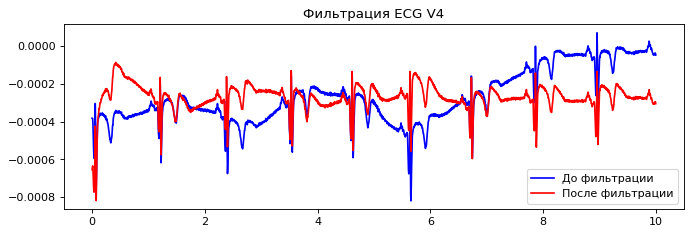

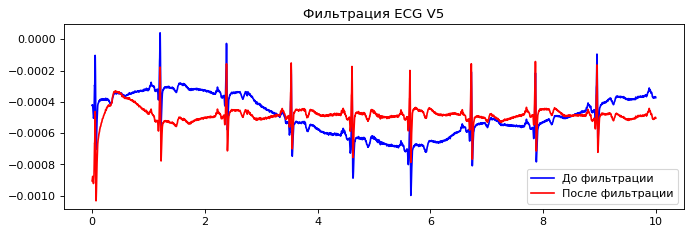

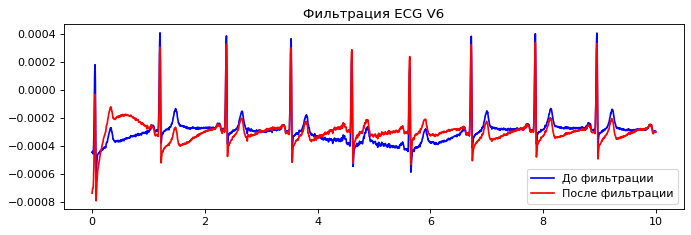

Вот, как ML модель распознала QRS пики после фильтрации сигнала:


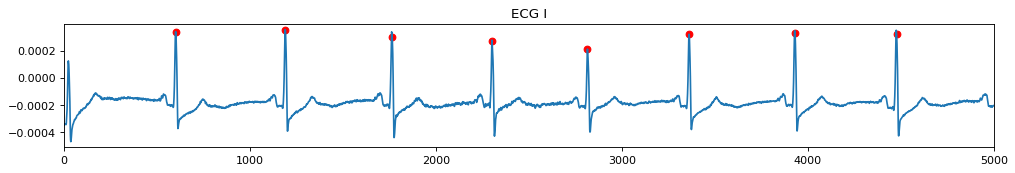

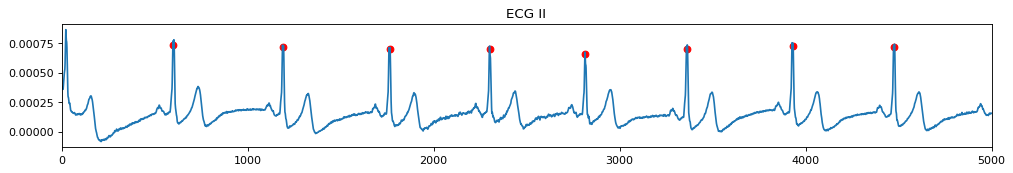

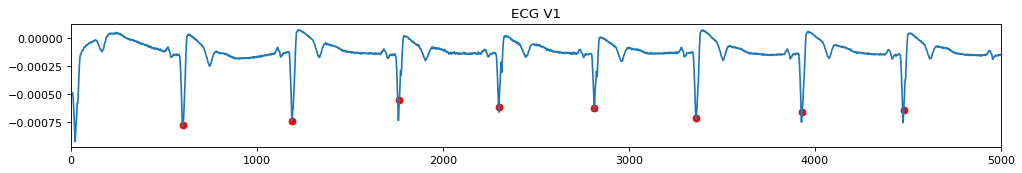

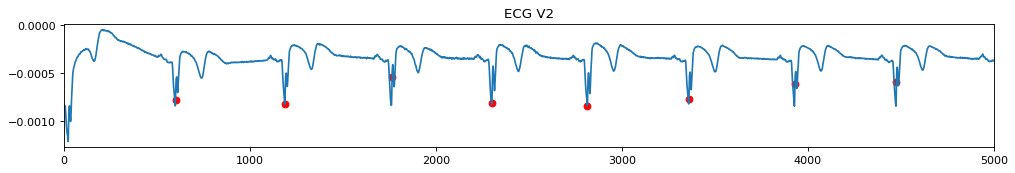

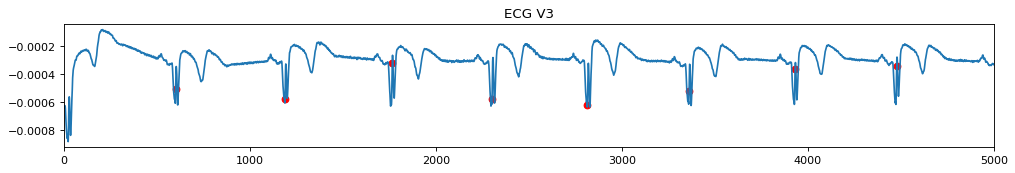

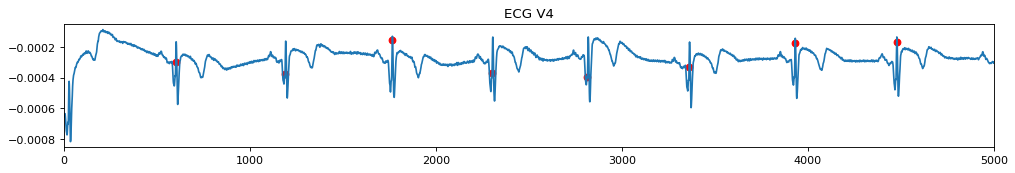

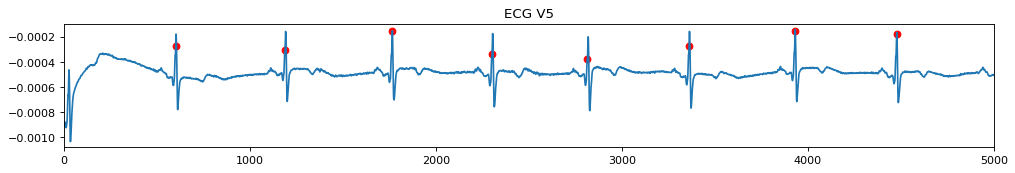

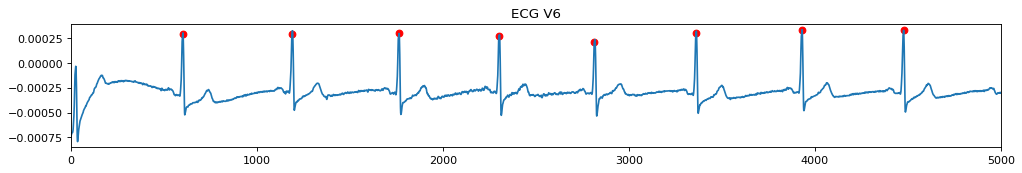

Запрошен диапазон с 3 по 4 период включительно
Результаты вычисления:


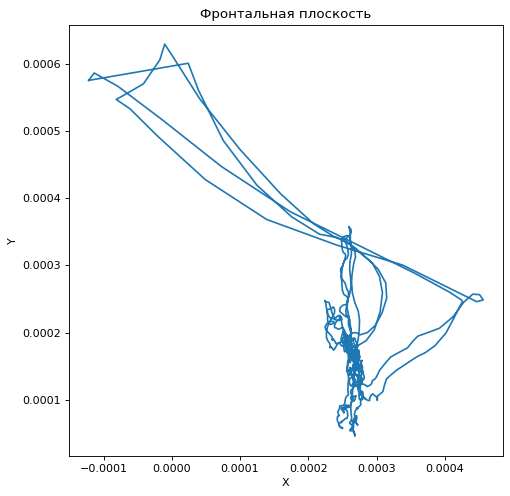

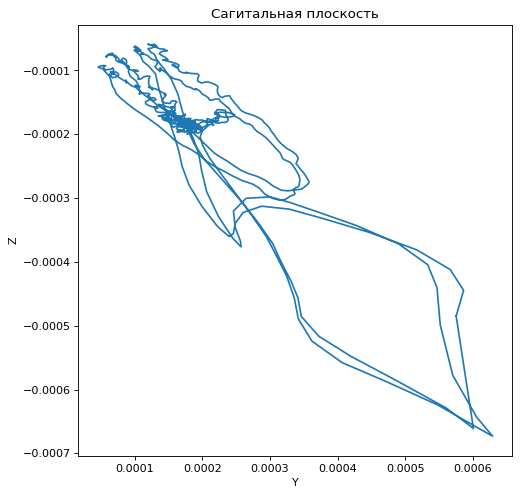

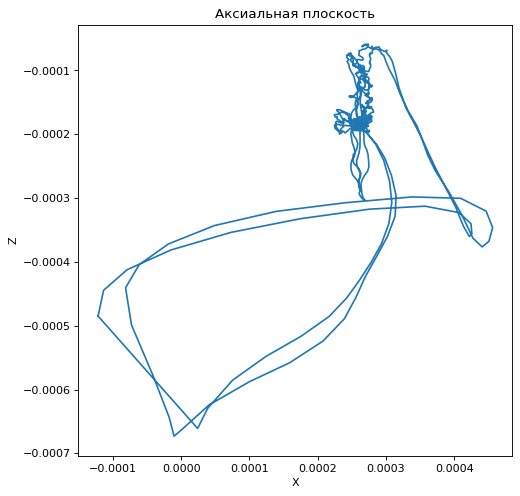

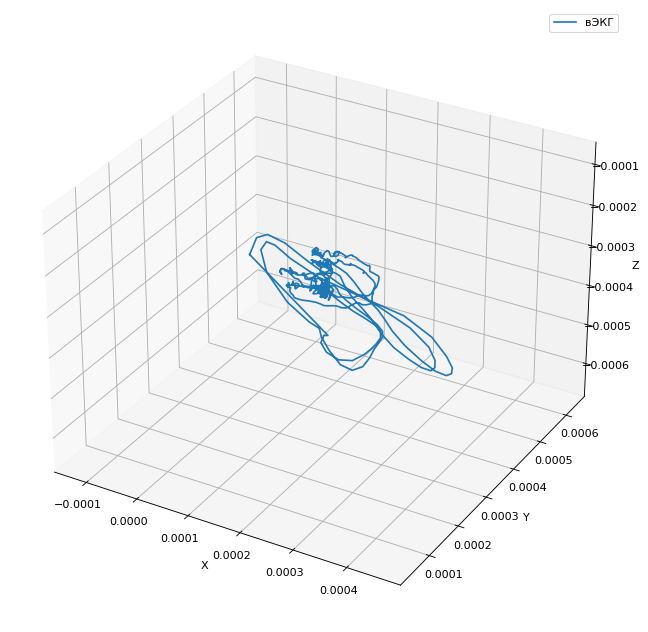

In [42]:
function(file="Data VECG\PatientA__Exam_1_0.edf", n_term=[3,4], filt=True, f_sreza=0.5)

---

# Результаты работы функций на реальных испытуемых:

Дмитрий:

Extracting EDF parameters from d:\Python_notebooks\repository_Koldim2001\vector_ECG\Data VECG\EKG_Dima.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Запрошен 3 период
Результаты вычисления:


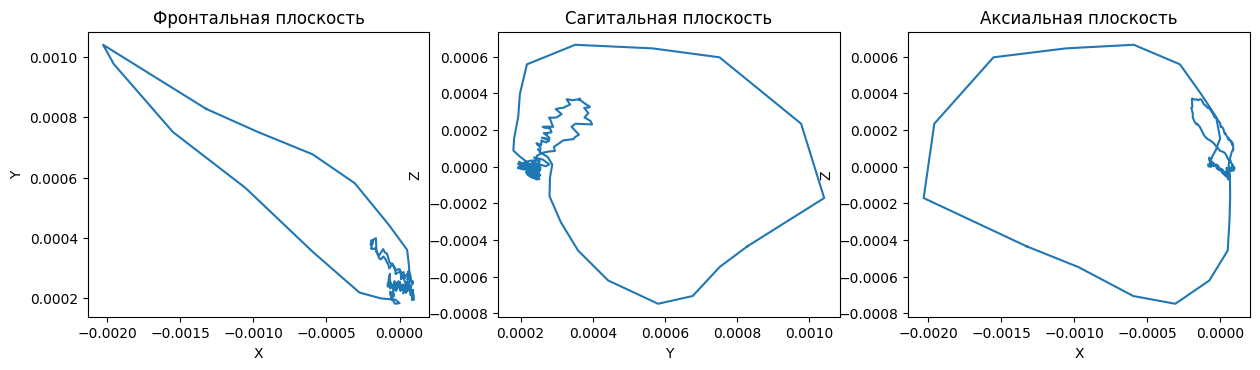

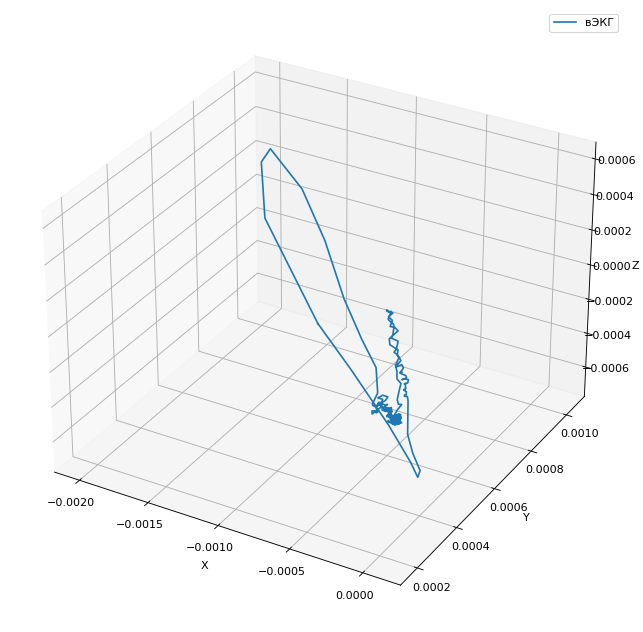

In [2]:
from func import *
vECG(file="Data VECG\EKG_Dima.edf", n_term=3, filt=True, f_sreza=0.5)

Паша:

Extracting EDF parameters from d:\Python_notebooks\repository_Koldim2001\vector_ECG\Data VECG\EKG_Pasha.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Запрошен 3 период
Результаты вычисления:


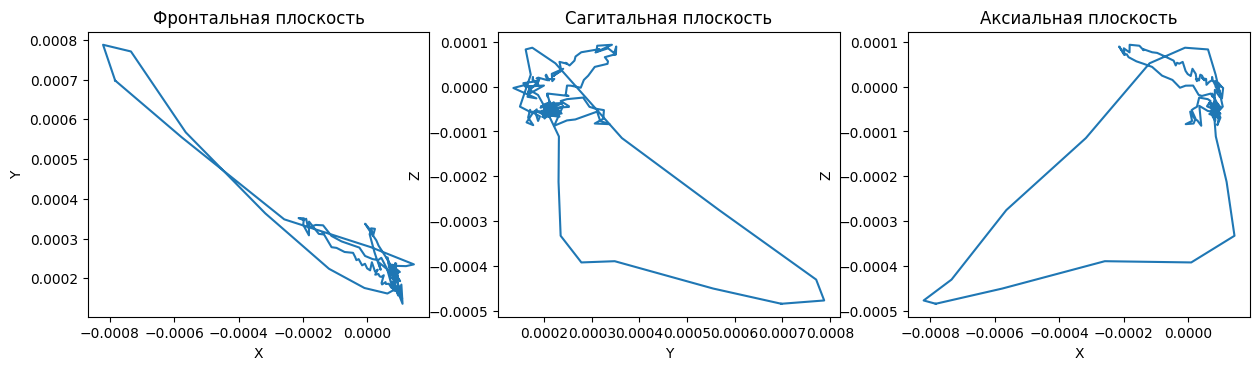

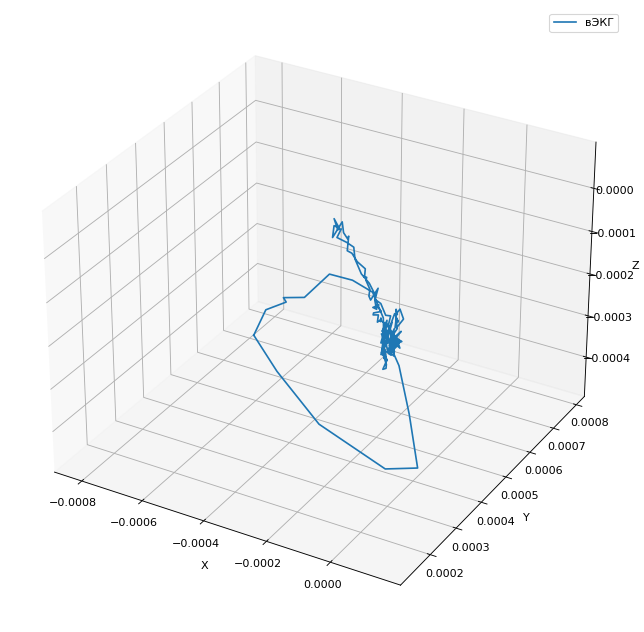

In [3]:
vECG(file="Data VECG\EKG_Pasha.edf", n_term=3, filt=True, f_sreza=0.5)

Раним:

Extracting EDF parameters from d:\Python_notebooks\repository_Koldim2001\vector_ECG\Data VECG\EKG_Ranim.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Запрошен 3 период
Результаты вычисления:


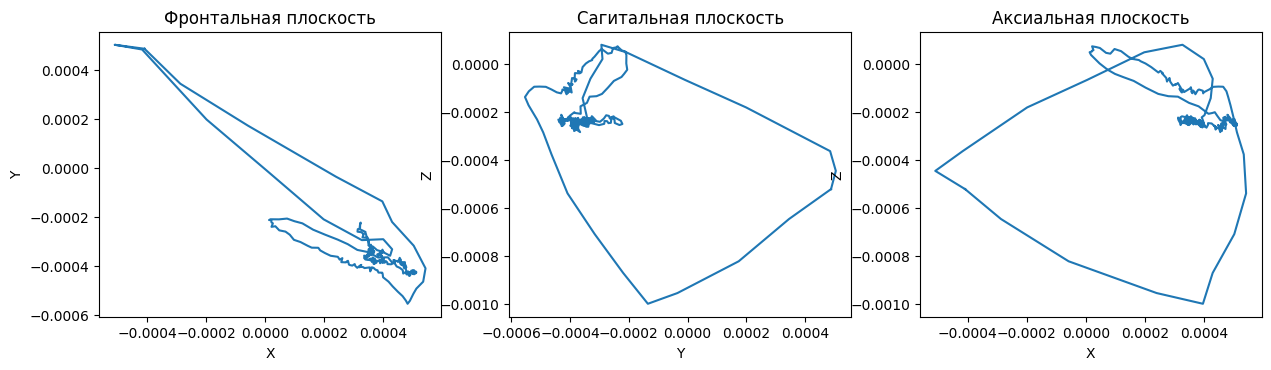

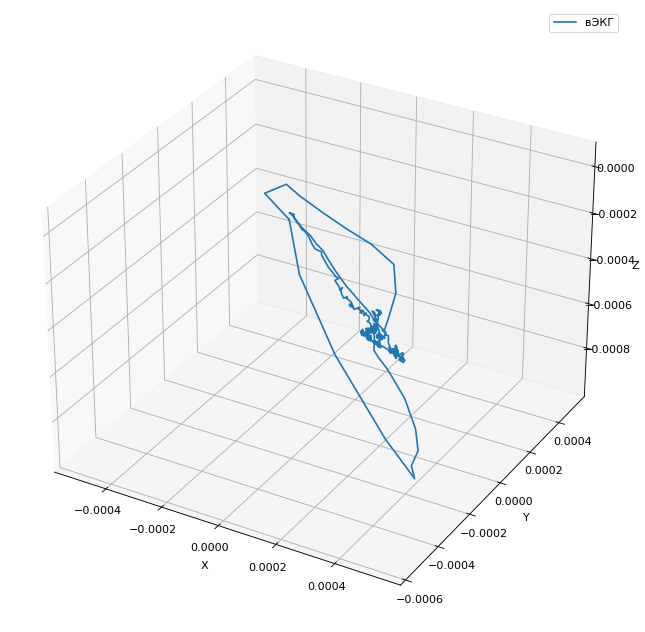

In [5]:
vECG(file="Data VECG\EKG_Ranim.edf", n_term=3, filt=True, f_sreza=0.5)